In [503]:
import warnings
warnings.filterwarnings("ignore")
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [504]:
cm = 3
mN = 0.2
V2 = 1e-2    # used in reweighting the samples

mN_string = str(int(mN*1000))

In [505]:
df_eff = pd.read_csv("../data/eff_table.csv")
df_eff

,Type,Energy,Mass,Efficiency
0,s_M,3,200.0,0.261975
1,s_D,3,200.0,0.222220
2,b_MuMu_lllqqv,3,NaN,0.261975


In [506]:
df_eff['Energy']

0    3
1    3
2    3
Name: Energy, dtype: int64

In [507]:
df_eff[(df_eff.Energy==cm)]

,Type,Energy,Mass,Efficiency
0,s_M,3,200.0,0.261975
1,s_D,3,200.0,0.222220
2,b_MuMu_lllqqv,3,NaN,0.261975


In [508]:
# extract the reconstruction eff from the eff table

eff_M = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN*1000) & (df_eff.Type=='s_M')]['Efficiency'].values[0]
eff_D = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN*1000) & (df_eff.Type=='s_D')]['Efficiency'].values[0]
eff_baMu_qql = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_MuMu_lllqqv')]['Efficiency'].values[0]
# eff_baMu_qqv = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_aMu_qqv')]['Efficiency'].values[0]
# eff_bMuMu_qqlv = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_MuMu_qqlv')]['Efficiency'].values[0]
# eff_bMuMu_qqll = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_MuMu_qqll')]['Efficiency'].values[0]
# eff_baa_qqlv = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_aa_qqlv')]['Efficiency'].values[0]

In [509]:
# store the muon collider luminosity, Xsec, for later estimating the yields

Lumi = 1000000

V2_sim = 0.2**2

# corss section when |V|^2 = 1
Xsec_M = {3: {0.2: 3.70E+00 / V2_sim}}    # first key: sqrt{s}, second key: m_N
Xsec_D = {3: {0.2: 3.76E+00 / V2_sim}}
Xsec_bMuMu_lllqqv = {3: 3.83E+00}   # key: sqrt{s}
# Xsec_baMu_qqv = {3: 1.02E+01}
# Xsec_bMuMu_qqlv = {3: 6.03E+00}
# Xsec_bMuMu_qqll = {3: 3.16E+00}
# Xsec_baa_qqlv = {3: 3.88E-01}

In [515]:
# read the files, and calculate the corresponding yields

modes_dt = {
            1: {'mode': f'../data/features/sig_Maj_E-{cm}_m-{mN_string}_reco.root', 'yields': Lumi*Xsec_M[cm][mN]*eff_M*V2},
            2: {'mode': f'../data/features/sig_Dir_E-{cm}_m-{mN_string}_reco.root', 'yields': Lumi*Xsec_D[cm][mN]*eff_D*V2}, 
            3: {'mode': f'../data/features/bg_MuMu_lllqqv_E-{cm}_reco.root', 'yields': Lumi*Xsec_bMuMu_lllqqv[cm]*eff_baMu_qql},
           }

In [516]:
for k, v in modes_dt.items():
    print(f"{v['yields']:.2e}")
print()

b=0
for k, v in modes_dt.items():
    if (k < 3): continue
    b += v['yields']
    
print(f"{b:.2e}")

2.42e+05
2.09e+05
1.00e+06

1.00e+06


In [517]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        print("reading: ", v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = k    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
#         print(k, v)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('\ntrain size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [518]:
tr_te_size = 0.5 
df_train, df_test = load_train_test(modes_dt, tr_te_size)

df_train_o, df_test_o = df_train.copy(), df_test.copy()

reading:  ../data/features/sig_Maj_E-3_m-200_reco.root
reading:  ../data/features/sig_Dir_E-3_m-200_reco.root
reading:  ../data/features/bg_MuMu_lllqqv_E-3_reco.root

train size: 8796 (50.01%); test size: 8793 (49.99%)
data points per mode:  [5863, 5863, 5863]


In [519]:
def relabel(x):
    if x != 1 and x != 2:    # bkg
        return 0
    
    elif x == 1:     # Maj signal
        return 1
    
    elif x == 2:     # Dir signal
        return 2

In [520]:
features = ['ptLep', 'etaLep', 'ELep',      # lepton kinematics info 
            'chargeLep', 'lepisMu',         # lepton type info
            'DeltaPhijjl', 'DeltaRjjl',     # Delta phi & Delta R between jj(from W boson) and lepton
            'ptJJ', 'etaJJ', 'mJJ',         # jj(from W boson) momentum info
            'ptN', 'pzN',                   # reconstructed N 4 momentum info
            'EJet1', 'EJet2',               # energy inbalance of the jets, for W boson classification
            'ptFwMu'                        # Forward muon pT
           ]


In [521]:
# # relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [522]:
# trainging
X_train = df_train[features]
y_train = df_train['target']

# testing
X_test = df_test[features]
y_test = df_test['target']


In [523]:
np.unique(y_train)

array([0, 1, 2])

In [524]:

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.weight.values);
# xgbc1.fit(X_train, y_train);

In [525]:
# the "preds" means the prob. of the event being HNL (Maj/Dir)
# since the 0 index is the bkg, so the prob. of HNL is 1 - prob. of bkg

# scores for training
df_bdt_train_s = df_train[['target', 'weight']]
df_bdt_train_s.loc[:, 'preds'] = 1 - xgbc1.predict_proba(X_train)[:, 0]

# score for testing 
df_bdt_test_s = df_test[['target', 'weight']]
df_bdt_test_s.loc[:, 'preds'] = 1 - xgbc1.predict_proba(X_test)[:, 0]


In [526]:
def bdt_cut(df, cut):
    df1 = df[(df['preds'] >= cut)]    # pass cut to be classified as HNL
#    "/ 2" because the samples include M & D. now assume they are just half half
    S1 = df1[df1['target'] != 0]['weight'].values.sum() / 2    # Number of signals
    B1 = df1[df1['target'] == 0]['weight'].values.sum()    # Number of bkg.
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1)))




# looping to find the optimal cut
def find_opt_cut(df_bdt_train_s, step=0.01):
    # cuts
    cuts = np.arange(0, 1, step)
    
    # store cuts
    c_lt = []
    # store losses
    loss1, loss2 = [], []
    snr = []

    # loop over two cuts
    for i1, c1 in enumerate(cuts):
        print("{}/{}".format(i1, len(cuts)), end='\r')
        res = bdt_cut(df_bdt_train_s, c1)
        c_lt.append(c1)    
        loss1.append(res[0])
        loss2.append(res[1])
        snr.append(res[2])
        
    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c_lt, loss1, loss2, snr]).T
    df_bdt_loss.columns = ['c', 'loss1', 'loss2', 'snr']

    df_bdt_loss['loss'] = (df_bdt_loss['loss1']**2 + df_bdt_loss['loss2']**2)**0.5
    df_bdt_loss['tot'] = (df_bdt_loss['loss'] - df_bdt_loss['loss'].min())/(df_bdt_loss['loss'].max() - df_bdt_loss['loss'].min()) - \
                        ((df_bdt_loss['snr'] - df_bdt_loss['snr'].min())/(df_bdt_loss['snr'].max() - df_bdt_loss['snr'].min()))
    
    return df_bdt_loss.iloc[df_bdt_loss['tot'].argmin()][['c']].values

In [527]:
# the optimal threshold
threshold = find_opt_cut(df_bdt_train_s)[0]

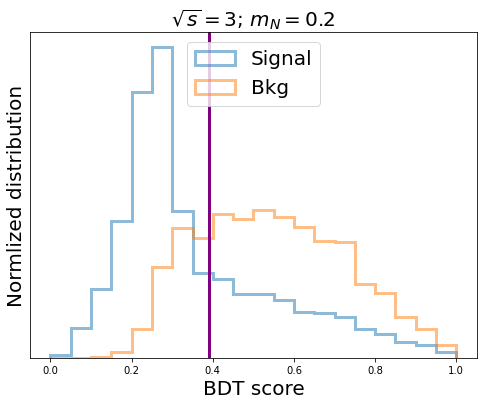

In [528]:
# BDT score distribution 

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s
# df_plot = df_bdt_train_s

range_=[0, 1]
bins_=20

ax1.hist(df_plot[df_plot.target!=0]['preds'], weights=df_plot[df_plot.target!=0]['weight']/sum(df_plot[df_plot.target!=0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_plot[df_plot.target==0]['preds'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg', alpha=0.5);

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
ax1.axvline(threshold, color='purple', lw=3)

# ax1.set_yscale('log')




# =================================================================================
# Apply BDT score cut
df_bdt_cut = df_bdt_test_s[(df_bdt_test_s['preds'] >= threshold)]
# =================================================================================



In [529]:
# separate to Maj/Dir/bkg

df_bdt_cut['iEvt'] = df_test_o.loc[df_bdt_cut.index]['iEvt']
df_bdt_cut['mN'] = df_test_o.loc[df_bdt_cut.index]['mN']
df_bdt_cut['lepisEle'] = df_test_o.loc[df_bdt_cut.index]['lepisEle']
df_bdt_cut['lepisMu'] = df_test_o.loc[df_bdt_cut.index]['lepisMu']
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]
df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] != 1) & (df_bdt_cut['target'] != 2)]


Mass range: [190.0, 204.99999999999997]


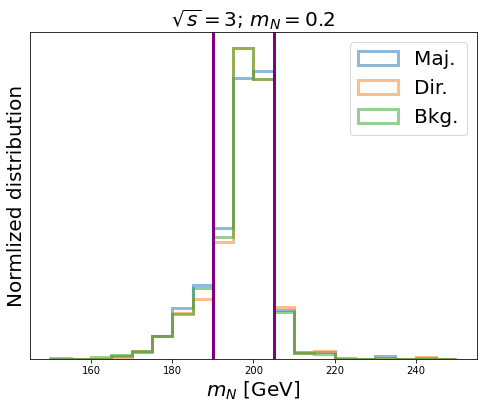

In [530]:
# mN distribution after BDT cut

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

range_ = [mN*(1-0.25)*1000, mN*(1+0.25)*1000]
# range_ = [0, 1000]

bins_=20
ax1.hist(df_bdt_cut1['mN'], weights=[1/len(df_bdt_cut1)]*len(df_bdt_cut1), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Maj.', color='C0');
ax1.hist(df_bdt_cut2['mN'], weights=[1/len(df_bdt_cut2)]*len(df_bdt_cut2), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Dir.', color='C1');
ax1.hist(df_bdt_cut0['mN'], weights=[1/len(df_bdt_cut0)]*len(df_bdt_cut0), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg.', color='C2');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m_N ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)

# mass range cut
partition_u = 0.025
partition_l = 0.05
ax1.axvline(1000*mN*(1-partition_l), color='purple', lw=3)
ax1.axvline(1000*mN*(1+partition_u), color='purple', lw=3)

print("Mass range: [{}, {}]".format(1000*mN*(1-partition_l), 1000*mN*(1+partition_u)))

# f.savefig('./figures/mN')

# =========================================================================================
# manully apply cut on mN
df_bdt_cut['mN'] = df_test_o.loc[df_bdt_cut.index]['mN']
df_bdt_cut = df_bdt_cut[(df_bdt_cut.mN>=1000*mN*(1-partition_l)) & (df_bdt_cut.mN<=1000*mN*(1+partition_u))]
# =========================================================================================


In [531]:
# yields after BDT and mass cuts

df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]   # Bkg
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]   # M
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]   # D

# yield (without |V|^2 dependence)
nb = df_bdt_cut0.weight.sum() / tr_te_size          # Bkg
nM = df_bdt_cut1.weight.sum() / tr_te_size / V2    # M
nD = df_bdt_cut2.weight.sum() / tr_te_size / V2    #  D

print('yields: ')
print(f'Bkg:\t{nb:.2e}')
print(f'(M):\t{nM:.2e} x |V|^2')
print(f'(D):\t{nD:.2e} x |V|^2')

yields: 
Bkg:	2.92e+05
(M):	2.84e+06 x |V|^2
(D):	2.63e+06 x |V|^2


In [532]:
# eff. of the BDT and mass cuts

eff0 = len(df_bdt_cut0) / len(df_test_o[(df_test_o.target!=1) & (df_test_o.target!=2)])
eff1 = len(df_bdt_cut1) / len(df_test_o[df_test_o.target==1])
eff2 = len(df_bdt_cut2) / len(df_test_o[df_test_o.target==2])

print("BDT eff:")
print("bkg:\t{:2f}%".format(100*eff0))
print("Maj:\t{:2f}%".format(100*eff1))
print("Dir:\t{:2f}%".format(100*eff2))

BDT eff:
bkg:	29.102695%
Maj:	11.702491%
Dir:	12.589560%


In [533]:
# limits on |V|^2

N = 1.96
M = N**2

print('Fully Majorana case:')
upperM, lowerM = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nM), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nM)
print(f"upper limit on |V|^2: {upperM:.2e}")
print(f"lower limit on |V|^2: {lowerM:.2e}")
print()

print('Fully Dirac case:')
upperD, lowerD = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nD), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nD)
print(f"upper limit on |V|^2: {upperD:.2e}")
print(f"lower limit on |V|^2: {lowerD:.2e}")

Fully Majorana case:
upper limit on |V|^2: 3.74e-04
lower limit on |V|^2: -3.73e-04

Fully Dirac case:
upper limit on |V|^2: 4.04e-04
lower limit on |V|^2: -4.02e-04


In [534]:
# s/b ratio

print("s/b ratio: ")
print(f'# Maj signal / bkg = {nM/nb:.0f} x |V|^2')
print(f'# Dir signal / bkg = {nD/nb:.0f} x |V|^2')

s/b ratio: 
# Maj signal / bkg = 10 x |V|^2
# Dir signal / bkg = 9 x |V|^2


In [535]:
# s/sqrt(b)

print("s/sqrt(b) ratio: ")
print(f'# Maj signal / sqrt(bkg) = {nM/(nb)**0.5:.0f} x |V|^2')
print(f'# Dir signal / sqrt(bkg) = {nD/(nb)**0.5:.0f} x |V|^2')

s/sqrt(b) ratio: 
# Maj signal / sqrt(bkg) = 5247 x |V|^2
# Dir signal / sqrt(bkg) = 4866 x |V|^2


In [536]:
# importance of the features used in BDT
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))

{'ptLep': 1794.0,
 'etaLep': 1092.0,
 'mJJ': 934.0,
 'DeltaPhijjl': 868.0,
 'ptJJ': 704.0,
 'ptFwMu': 702.0,
 'etaJJ': 692.0,
 'ELep': 670.0,
 'DeltaRjjl': 626.0,
 'ptN': 569.0,
 'pzN': 508.0,
 'chargeLep': 71.0}

In [40]:
# get the prediction score for Maj/Dir
# df_bdt_test_s['target'] = df_test_o.loc[df_bdt_test_s.index]['target']
df_bdt_test_s['target'] = df_test_o.loc[df_test.index]['target']
df_bdt_test_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_test)[:, 1]
df_bdt_test_s.loc[:, 'pred2'] = xgbc1.predict_proba(X_test)[:, 2]

df_bdt_test_s['target'] = df_bdt_test_s['target'].apply(relabel)

# only get events that survive in the BDT and mass cut
df_bdt_test_s = df_bdt_test_s.loc[df_bdt_cut.index]

In [41]:
def bdt_cut_2(df, cut1, cut2, signal1=1, signal2=2):
    df1 = df[(df['pred1'] >= cut1) & (df['pred2'] < cut2)]    # pass tau cut, not pass mu cut
    df2 = df[(df['pred1'] < cut1) & (df['pred2'] >= cut2)]    # pass mu cut, not pass tau cut
    
    S1 = df1[df1['target'] == signal1]['weight'].values.sum()    # Number of tau signals
    B1 = df1[df1['target'] != signal1]['weight'].values.sum()    # Number of tau bkg.
    
    S2 = df2[df2['target'] == signal2]['weight'].values.sum()    # Number of mu signals
    B2 = df2[df2['target'] != signal2]['weight'].values.sum()    # Number of mu bkg.
    
    return ((S1+B1)**0.5, (0.1*B1), S1/(np.sqrt(S1+B1))), ((S2+B2)**0.5, (0.1*B2), S2/(np.sqrt(S2+B2)))






# looping to find the optimal cut
def find_opt_cut_2(df_bdt_train_s, step=0.01):

    # tau cut
#     cuts1 = np.arange(round(df_bdt_train_s.min()['pred0'], 2) - step, round(df_bdt_train_s.max()['pred0'], 2) + step, step)
    cuts1 = np.arange(0, 1, step)
    # mu cut
    cuts2 = np.arange(0, 1, step)

    # store cuts (tau, and mu)
    c1_lt, c2_lt = [], []
    # store losses
    loss11, loss12 = [], []
    loss21, loss22 = [], []
    snr1, snr2 = [], []

    # loop over two cuts
    for i1, c1 in enumerate(cuts1):
        for i2, c2 in enumerate(cuts2):
            print("{}/{}; {}/{}".format(i1, len(cuts1), i2, len(cuts2)), end='\r')
            res1, res2 = bdt_cut_2(df_bdt_train_s, c1, c2)
            c1_lt.append(c1); c2_lt.append(c2)

            loss11.append(res1[0]); loss12.append(res1[1])
            loss21.append(res2[0]); loss22.append(res2[1])
            snr1.append(res1[2]), snr2.append(res2[2])

    # store the cuts and corresponding losses
    df_bdt_loss = pd.DataFrame([c1_lt, c2_lt, loss11, loss12, snr1, loss21, loss22, snr2]).T
    df_bdt_loss.columns = ['c1', 'c2', 'loss11', 'loss12', 'snr1', 'loss21', 'loss22', 'snr2']

    df_bdt_loss['loss1'] = (df_bdt_loss['loss11']**2 + df_bdt_loss['loss12']**2)**0.5
    df_bdt_loss['tot1'] = (df_bdt_loss['loss1'] - df_bdt_loss['loss1'].min())/(df_bdt_loss['loss1'].max() - df_bdt_loss['loss1'].min()) - \
        ((df_bdt_loss['snr1'] - df_bdt_loss['snr1'].min())/(df_bdt_loss['snr1'].max() - df_bdt_loss['snr1'].min()))

    df_bdt_loss['loss2'] = (df_bdt_loss['loss21']**2 + df_bdt_loss['loss22']**2)**0.5
    df_bdt_loss['tot2'] = (df_bdt_loss['loss2'] - df_bdt_loss['loss2'].min())/(df_bdt_loss['loss2'].max() - df_bdt_loss['loss2'].min()) - \
        ((df_bdt_loss['snr2'] - df_bdt_loss['snr2'].min())/(df_bdt_loss['snr2'].max() - df_bdt_loss['snr2'].min()))

    df_bdt_loss['tot'] = df_bdt_loss['tot1'] + df_bdt_loss['tot2']

    return df_bdt_loss.iloc[df_bdt_loss['tot'].argmin()][['c1', 'c2']].values

In [42]:
cutM, cutD = find_opt_cut_2(df_bdt_test_s)

KeyboardInterrupt: 

In [ ]:
# BDT score distribution 

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s

range_=[0, 1]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['pred1'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
ax1.hist(df_plot[df_plot.target==2]['pred1'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['pred1'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score (HNL=Maj.)', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
ax1.set_yscale('log')
ax1.axvline(cutM)





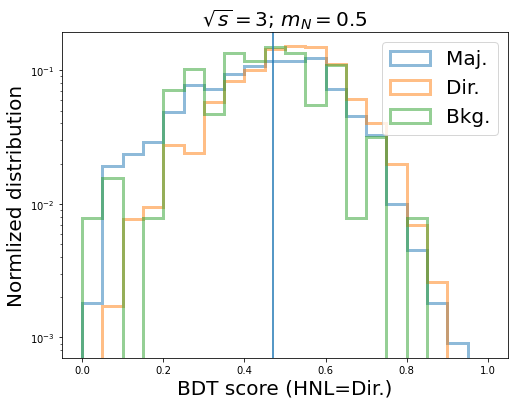

In [408]:
# BDT score distribution 

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s

range_=[0, 1]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['pred2'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
ax1.hist(df_plot[df_plot.target==2]['pred2'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['pred2'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score (HNL=Dir.)', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
ax1.set_yscale('log')
ax1.axvline(cutD)






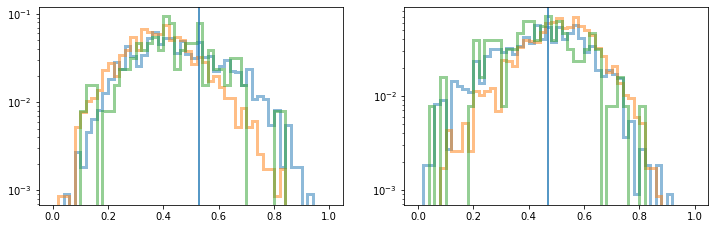

In [409]:
# Distributions of Maj/Dir/bkg. regions

plt.figure(figsize=(12,8))

ax1 = plt.subplot(221)
range_=[0,1]
bins_=50

# Maj. region
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.axvline(cutM)
ax1.set_yscale('log')

# Dir. region
ax2 = plt.subplot(222)
range_=[0,1]
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax2.axvline(cutD)
ax2.set_yscale('log')

# # Bkg. region
# ax3 = plt.subplot(223)
# range_=[0,1]
# ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==1)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
# ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==2)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
# ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==0)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
# # cutD=0.5
# ax3.axvline(threshold)
# ax3.set_yscale('log')

In [410]:
# get the expected yields at the corresponding regions (after BDT and mass cuts)
def get_M_block(V2_test=1e-5):
#     pass Maj. not pass Dir. => Maj. region
    df_M = df_bdt_test_s[(df_bdt_test_s.pred1>cutM) & (df_bdt_test_s.pred2<=cutD)]
#     number of Bkg., Maj., Dir. in the Maj. region
    M0, M1, M2 = df_M[df_M.target==0].weight.sum()/tr_te_size, df_M[df_M.target==1].weight.sum()/tr_te_size, df_M[df_M.target==2].weight.sum()/tr_te_size
#     rescale Maj/Dir by the V2_test
    M1, M2 = M1/V2*V2_test, M2/V2*V2_test
    return M0, M1, M2

def get_D_block(V2_test=1e-5):
#     not pass Maj. pass Dir. => Dir. region
    df_D = df_bdt_test_s[(df_bdt_test_s.pred1<=cutM) & (df_bdt_test_s.pred2>cutD)]
#     number of Bkg., Maj., Dir. in the Maj. region
    D0, D1, D2 = df_D[df_D.target==0].weight.sum()/tr_te_size, df_D[df_D.target==1].weight.sum()/tr_te_size, df_D[df_D.target==2].weight.sum()/tr_te_size
#     rescale Maj/Dir by the V2_test
    D1, D2 = D1/V2*V2_test, D2/V2*V2_test
    return D0, D1, D2

    
# number of events in Maj region
def N_M(r, M_M, D_M, B_M):
    return r*M_M + (1-r)*D_M + B_M
    
# number of events in Dir region
def N_D(r, M_D, D_D, B_D):
    return r*D_D + (1-r)*M_D + B_D

# log likelihood
# r_t: simulated (means if in the real world, the real mixing is r_t); 
# r: r_hat
def lnL(r, r_t, M_M, D_M, B_M, M_D, D_D, B_D):
    NM = N_M(r, M_M, D_M, B_M)
    NMt = N_M(r_t, M_M, D_M, B_M)
    ND = N_D(r, M_D, D_D, B_D)
    NDt = N_D(r_t, M_D, D_D, B_D)
    
    lnL_M = (NMt)*np.log(NM) - (NMt*np.log(NMt)-NMt) - NM
    lnL_D = (NDt)*np.log(ND) - (NDt*np.log(NDt)-NDt) - ND
    return lnL_M + lnL_D

In [411]:
V2_test = upperM
# V2_test = 1e-5
M0, M1, M2 = get_M_block(V2_test)
D0, D1, D2 = get_D_block(V2_test)

r = np.arange(0, 1.0000000001, 0.0001)
rt_lt = np.arange(0, 1.00000000001, 0.01)

def get_bounds(r, sd):
#     significant level
    sig = sd**2
    upper_lt = []
    lower_lt = []

    for i, rt in enumerate(rt_lt):
        if i%100 == 0:
            print(rt, end='\r')
#         array of values of different r (r_hat) with a specific r (simulated r)
        lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

#         storing the upper bound
        if rt == 1:
            upper_lt.append(np.nan)
        else:
#             find the index of r which gives the closest value to the corresponding significant level
            i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-sig/2))) + np.argmax(lnL_val) 
            if abs(np.max(lnL_val)-sig/2 / lnL_val[i_r] - 1) < 1/100:
                upper_lt.append(r[i_r])
            else: 
                upper_lt.append(np.nan)
        
#         storing the lower bound
        if rt == 0:
            lower_lt.append(np.nan)
        else:
#             find the index of r which gives the closest value to the corresponding significant level
            i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-sig/2)))
            if abs(np.max(lnL_val)-sig/2 / lnL_val[i_l] - 1) < 1/100:
                lower_lt.append(r[i_l])
            else: 
                lower_lt.append(np.nan)
    
    upper_lt, lower_lt = np.array(upper_lt), np.array(lower_lt)
    return upper_lt, lower_lt

In [412]:
# one sigma
upper_lt1, lower_lt1 = get_bounds(r, 1)
# two sigma
upper_lt2, lower_lt2 = get_bounds(r, 2)

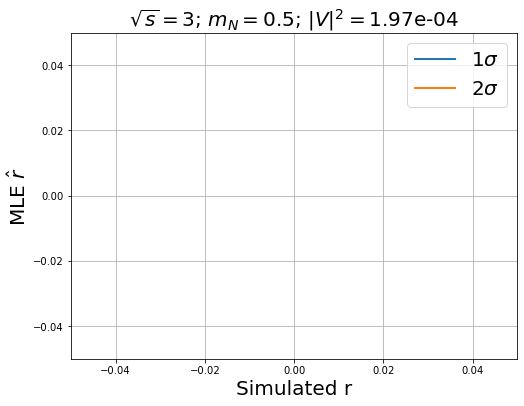

In [413]:

f = plt.figure(figsize=(8,6))

plt.plot(rt_lt, upper_lt1, color='C0', label=r'$1\sigma$', lw=2)
plt.plot(rt_lt, lower_lt1, color='C0', lw=2)

plt.plot(rt_lt, upper_lt2, color='C1', label=r'$2\sigma$', lw=2)
plt.plot(rt_lt, lower_lt2, color='C1', lw=2)

plt.legend(fontsize=20)

plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN)+"; $|V|^2=$"+f"{V2_test:.2e}", fontsize=20)
plt.xlabel("Simulated r", fontsize=20);
plt.ylabel(r"MLE $\hat{r}$", fontsize=20);

plt.margins(y=0)
plt.margins(x=0)

plt.grid()


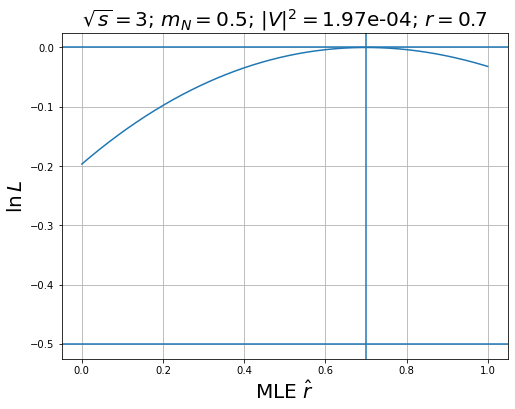

In [414]:
# exmaple of a slide with specific r_t (simulated r)
rt = 0.7   # if the measured data is such value

f = plt.figure(figsize=(8,6))

r = np.arange(0, 1.00000000001, 0.0001)

lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

plt.plot(r, lnL_val)    # loop over possible r, to find the one max the liklihood
plt.axvline(rt)
plt.axhline(np.max(lnL_val))
plt.axhline(np.max(lnL_val)-1/2)

i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-1/2))) + np.argmax(lnL_val) 
if abs(np.max(lnL_val)-1/2 / lnL_val[i_r] - 1) < 1/100:
    plt.axvline(r[i_r])

i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-1/2)))
if abs(np.max(lnL_val)-1/2 / lnL_val[i_l] - 1) < 1/100:
    plt.axvline(r[i_l])

    
plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN)+"; $|V|^2=$"+f"{V2_test:.2e}; "+f"$r={rt}$", fontsize=20)
plt.xlabel(r"MLE $\hat{r}$", fontsize=20);
plt.ylabel(r"$\ln{L}$", fontsize=20);
plt.grid()

In [415]:
# width of one sigma (since it is asymmetric, so need to separate upper and lower)
sigma_pos = upper_lt1 - rt_lt
sigma_neg = rt_lt - lower_lt1 

df_sigma = pd.DataFrame(columns=['r', 'sigma_pos', 'sigma_neg'])
df_sigma['r'] = rt_lt
df_sigma['sigma_pos'] = sigma_pos
df_sigma['sigma_neg'] = sigma_neg

df_sigma_pos = df_sigma[['r', 'sigma_pos']].dropna()
df_sigma_neg = df_sigma[['r', 'sigma_neg']].dropna()

# avg of them 
df_sigma['avg'] = df_sigma[['sigma_pos', 'sigma_neg']].mean(axis=1)

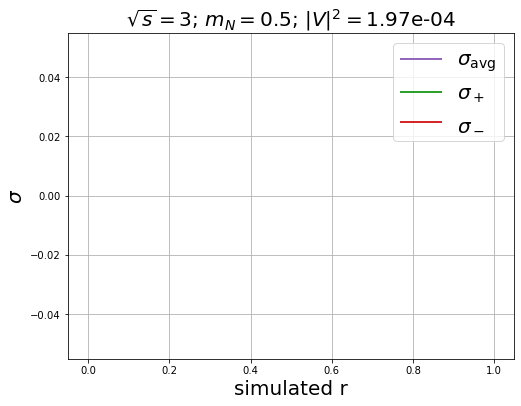

In [416]:

f = plt.figure(figsize=(8,6))
plt.plot(df_sigma['r'], df_sigma['avg'], lw=2, c='C4', label=r'$\sigma_{\rm avg}$')
plt.plot(df_sigma['r'], df_sigma['sigma_pos'], lw=2, c='C2', label=r'$\sigma_+$')
plt.plot(df_sigma['r'], df_sigma['sigma_neg'], lw=2, c='C3', label=r'$\sigma_-$')
plt.legend(fontsize=20)

plt.xlabel("simulated r", fontsize=20);
plt.ylabel(r"$\sigma$", fontsize=20);
plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN)+"; $|V|^2=$"+f"{V2_test:.2e}", fontsize=20)
plt.xlim(-0.05, 1.05)
plt.grid()

In [417]:
# get the limit of |V|^2 to reject the null hypothesis H0 (e.g. r0=1 means fully Maj)
def get_limit(r0=1, sd=1):
    rt_lt = np.arange(0,1.00000000001,0.01)

    V2_dt = {}
#     loop over each possible r_t (truth r in the real world)
    for rt in rt_lt:
        if rt==r0:
            V2_dt[rt] = np.nan
            continue
            
#         set some inital V2
        V2_test = 1e-3
        print(rt, end='\r')
        while True:
#             calculate the significance
            M0, M1, M2 = get_M_block(V2_test)
            D0, D1, D2 = get_D_block(V2_test)
            lnL_valr = lnL(rt, rt, M1, M2, M0, D1, D2, D0)
            lnL_val0 = lnL(r0, rt, M1, M2, M0, D1, D2, D0)
            Z = (-2*(lnL_val0 - lnL_valr))**0.5

#             if it is close enough to the targeted signifiant level, 
#             then store the vlaue and stop the loop
            if abs(Z/sd-1) < 0.5/100:
                V2_dt[rt] = V2_test
                break
#              if it is too large, halve the V2 and re calculate the significance 
            elif Z > sd:
                V2_test /= 2
#             if it is too small, make the V2 a little bit larger
            elif Z < sd:
                V2_test = 10**(np.log10(V2_test)*0.999) 
    return V2_dt

In [418]:
V2_dt_r0_1sd = get_limit(r0=0, sd=1.)
V2_dt_r1_1sd = get_limit(r0=1, sd=1.)

V2_dt_r0_2sd = get_limit(r0=0, sd=2.)
V2_dt_r1_2sd = get_limit(r0=1, sd=2.)

KeyboardInterrupt: 

In [ ]:

f = plt.figure(figsize=(8,6))
plt.plot(V2_dt_r0_1sd.keys(), V2_dt_r0_1sd.values(), label=r'$H_0: r=0$ at $1\sigma$', c='C1')
plt.plot(V2_dt_r1_1sd.keys(), V2_dt_r1_1sd.values(), label=r'$H_0: r=1$ at $1\sigma$', c='C0')
plt.plot(V2_dt_r0_2sd.keys(), V2_dt_r0_2sd.values(), label=r'$H_0: r=0$ at $2\sigma$', c='C1', linestyle='--')
plt.plot(V2_dt_r1_2sd.keys(), V2_dt_r1_2sd.values(), label=r'$H_0: r=1$ at $2\sigma$', c='C0', linestyle='--')
plt.yscale('log')
# plt.margins(y=0.25)

# plt.axhline(upperM)

plt.title(r"min. $|V|^2$ to reject $H_0$"+"\n"+r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
plt.xlabel("simulated r", fontsize=20);
plt.ylabel(r"$|V|^2$", fontsize=20);
plt.grid()
plt.legend(fontsize=20)

plt.yscale('log')

In [322]:
df_plot = pd.concat([df_train, df_test])

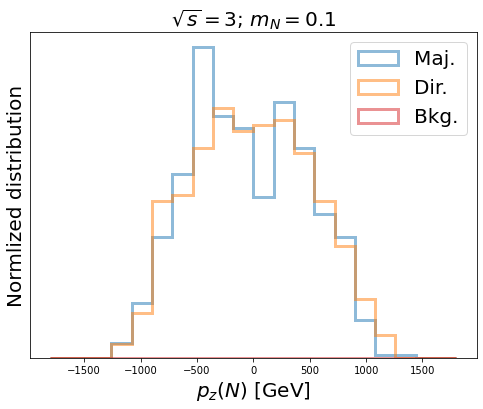

In [323]:
f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


range_=[-1800, 1800]
bins_=20

ax1.hist(df_plot[df_plot.target==1]['pzN'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Maj.', alpha=0.5, color='C0');
ax1.hist(df_plot[df_plot.target==2]['pzN'], weights=df_plot[df_plot.target==2]['weight']/sum(df_plot[df_plot.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Dir.', alpha=0.5, color='C1');
ax1.hist(df_plot[df_plot.target==0]['pzN'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C3');

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$p_z(N)$ [GeV]', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20);

# ax1.set_yscale('log')



In [324]:
np.unique(df_plot.target)

array([1, 2, 3])

In [348]:
df_plot = pd.concat([df_train_o, df_test_o])
df_maj = df_plot[df_plot.target==1]
df_dir = df_plot[df_plot.target==2]

In [210]:
df_maj['etaDiff'] = (df_maj['etaJJTrue'] - df_maj['etaLepTrue'])
df_maj['phiDiff'] = abs(df_maj['phiJJTrue'] - df_maj['phiLepTrue'])

In [211]:
df_maj.loc[df_maj['phiDiff'] > np.pi, 'phiDiff'] = 2*np.pi - df_maj.loc[df_maj['phiDiff'] > np.pi, 'phiDiff']

In [159]:
df_maj.phiDiff.max()


6.282980442047119

In [212]:
df_maj['DeltaR'] = ((df_maj['phiDiff'])**2 + (df_maj['etaDiff'])**2)**0.5

In [160]:
2 * np.pi

6.283185307179586

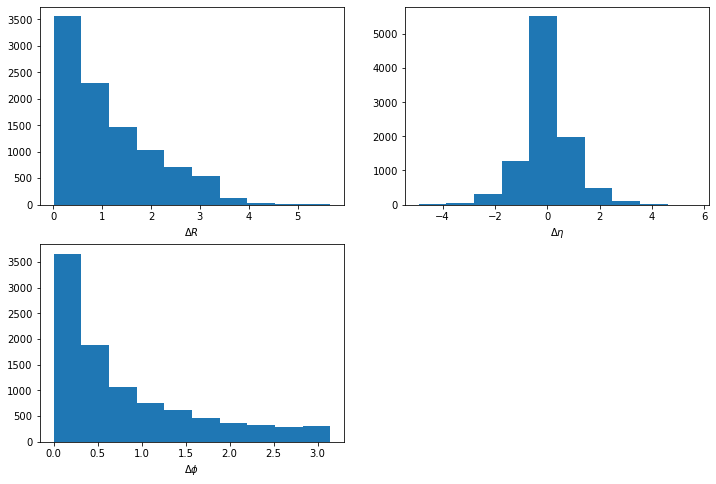

In [213]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(221)
ax1.hist(df_maj['DeltaR']);
ax1.set_xlabel(r'$\Delta R$');

ax2 = plt.subplot(222)
ax2.hist(df_maj['etaDiff']);
ax2.set_xlabel(r'$\Delta\eta$');

ax3 = plt.subplot(223)
ax3.hist(df_maj['phiDiff']);
ax3.set_xlabel(r'$\Delta\phi$');

In [217]:
np.sum(abs(df_maj['etaLep'] / df_maj['etaLepTrue'] - 1)<1)

7545

In [216]:
len(df_maj)

9776

In [218]:
np.sum(abs(df_maj['etaLep'] / df_maj['etaLepTrue'] - 1)<1) / len(df_maj)

0.7717880523731587

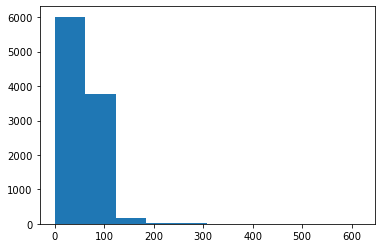

In [259]:
plt.hist(df_maj['mJJ'], bins=10);

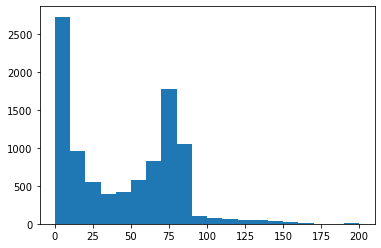

In [261]:
plt.hist(df_maj['mJJ'], range=[0, 200], bins=20);

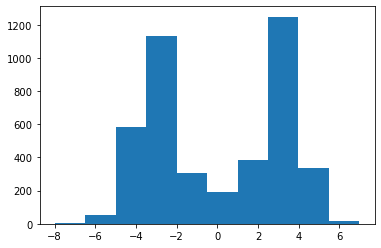

In [264]:
plt.hist(df_maj.loc[df_maj['mJJ']<25, 'etaJJTrue']);

In [453]:
df_plot = pd.concat([df_train_o, df_test_o])
df_maj = df_plot[df_plot.target==1]
df_dir = df_plot[df_plot.target==2]

In [456]:
df_plot

,iEvt,ptLep,etaLep,phiLep,ELep,pxLep,pyLep,pzLep,chargeLep,lepisEle,...,pyLepTrue,pzLepTrue,MET,DeltaPhiNMET,ptl2,pzl2,El2,mJJl2,target,weight
0,5672,285.863556,0.265530,1.256161,296.000488,88.466087,271.830322,76.800514,1,0,...,274.004120,77.121635,0.000,6.016270e+35,0.000000e+00,-2.446158e+18,0.000000e+00,-1.182411e-37,1,0.04195
1,16735,128.894989,-0.166217,-1.318530,130.679657,32.172104,-124.815361,-21.523325,-1,0,...,268.873901,217.784592,0.000,6.016270e+35,0.000000e+00,-2.446158e+18,0.000000e+00,-1.182411e-37,1,0.04195
2,1392,186.396683,-0.050343,-1.876725,186.632935,-56.138691,-177.741867,-9.387722,1,0,...,183.728088,-206.904266,0.000,6.016270e+35,0.000000e+00,-2.446158e+18,0.000000e+00,-1.182411e-37,1,0.04195
3,12628,333.320038,-0.645969,-0.497665,405.315338,292.888153,-159.118744,-230.604141,-1,0,...,101.991463,324.235229,0.000,6.016270e+35,0.000000e+00,-2.446158e+18,0.000000e+00,-1.182411e-37,1,0.04195
4,8844,119.289024,0.254609,-2.722450,123.176445,-108.963127,-48.547997,30.701220,-1,0,...,137.115997,439.287018,0.000,6.016270e+35,0.000000e+00,-2.446158e+18,0.000000e+00,-1.182411e-37,1,0.04195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11317,11462,105.552513,1.137388,-0.146714,181.511597,104.418541,-15.430513,147.665604,-1,0,...,0.000000,0.000000,-93.944,1.116399e-32,2.482456e-22,-1.297539e-18,-2.039093e+21,-3.523410e+16,3,0.08500
11318,98479,285.046600,-0.101465,0.449977,286.515137,256.672272,123.979446,-28.971766,1,1,...,0.000000,0.000000,-93.944,1.116399e-32,2.482456e-22,-1.297539e-18,-2.039093e+21,-3.523410e+16,3,0.08500
11319,84587,317.153687,-1.138674,-2.734880,545.959045,-291.282227,-125.463631,-444.392639,1,1,...,0.000000,0.000000,-93.944,1.116399e-32,2.482456e-22,-1.297539e-18,-2.039093e+21,-3.523410e+16,3,0.08500
11320,74516,139.278244,-2.180899,-0.631965,624.468201,112.379211,-82.276016,-608.738098,1,1,...,0.000000,0.000000,-93.944,1.116399e-32,2.482456e-22,-1.297539e-18,-2.039093e+21,-3.523410e+16,3,0.08500


In [457]:
len(df_maj[df_maj.chargeLep*df_maj.chargeLep2 == 1]) / len(df_maj[abs(df_maj.chargeLep*df_maj.chargeLep2) == 1]), \
len(df_maj[df_maj.chargeLep*df_maj.chargeLep2 == -1]) / len(df_maj[abs(df_maj.chargeLep*df_maj.chargeLep2) == 1])

(0.5081653926337735, 0.49183460736622653)

In [458]:
len(df_dir[df_dir.chargeLep*df_dir.chargeLep2 == 1]) / len(df_dir[abs(df_dir.chargeLep*df_dir.chargeLep2) == 1]), \
len(df_dir[df_dir.chargeLep*df_dir.chargeLep2 == -1]) / len(df_dir[abs(df_dir.chargeLep*df_dir.chargeLep2) == 1])

ZeroDivisionError: division by zero

In [443]:
df_maj.loc[df_maj.chargeLep*df_maj.chargeLep2 == 1, ['iEvt', 'chargeLep', 'chargeLep2']]

AttributeError: 'DataFrame' object has no attribute 'chargeLep2'

In [444]:
df_maj.loc[(df_maj.chargeLep*df_maj.chargeLep2 == -1) & (df_maj.lep2isMu==1), 
                                                         ['iEvt', 'chargeLep', 'chargeLep2', 'lep2isEle', 'lep2isMu']]

AttributeError: 'DataFrame' object has no attribute 'chargeLep2'